In [1]:
from dataclasses import dataclass
from functools import lru_cache
import glob
import os
from pathlib import Path
import pickle
from typing import Callable, Iterable, Mapping, Sequence

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
from skimage.transform import AffineTransform, warp
from tqdm import tqdm


# Comparative and Functional Evaluation of XAI Methods for Neonatal Pain Recognition Models

# 1. Extract XAI Maps

XAI Explainers:

- IntegratedGradients
- Saliency
- DeepLift
- Occlusion
- LayerGradCam
- GuidedGradCam
- Deconvolution
- GradientShap
- DeepLiftShap
- Lime

Baselines to Explainers:

- Canny Edge Detector
- Same XAI explainer, but with random weights initialization (for pre-trained models keep pre-trained weights?)

Models:

- NCNN
- VGGFace
- ViT_B_32

### XAI

In [ ]:
OUT_DIR = "RGU\\XAI_EXPLAINERS\\RANDOM"
RANDOM = True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
from collections import defaultdict

from tqdm import tqdm
from PIL import Image, ImageFilter

import torch
import numpy as np
import pandas as pd

from captum.attr import (
    IntegratedGradients,
    Saliency,
    DeepLift,
    Occlusion,
    LayerGradCam,
    GuidedGradCam,
    Deconvolution,
    GradientShap,
    DeepLiftShap,
    Lime,
    LayerAttribution,
)

from skimage.segmentation import slic

from utils.utils import create_folder, load_config
from dataloaders.presets import PresetTransform
from models import *

def perturb_fn(inputs):
    noise = torch.tensor(np.random.normal(0, 0.1, inputs.shape)).float().to(inputs.device)
    return noise, torch.clip(inputs - noise, 0, 1)

# --- Create superpixel feature mask for Captum ---
def make_feature_mask(img_tensor, n_segments=100):
    x = img_tensor.detach().cpu().squeeze(0)  # 3 x H x W
    x_np = x.numpy()
    x_np = (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-8)
    x_np = np.transpose(x_np, (1, 2, 0))  # H, W, 3

    seg = slic(x_np, n_segments=n_segments, compactness=10.0, sigma=0.0,
               start_label=0, channel_axis=2)

    seg_t = torch.from_numpy(seg).long().unsqueeze(0).unsqueeze(0)
    return seg_t, seg

# ------------------------------------------------------------------------------

device = 'cuda'


# ------------------------------------------------------------------------------

def resolve_experiment(exp_name: str, device: torch.device):
    if "NCNN" in exp_name:
        model = NCNN().to(device)
        return {
            "model": model,
            "img_size": 120,
            "transform": PresetTransform("NCNN").transforms,
            "layer": model.merge_branch[0],
            "model_name": exp_name,
        }
    if "VGGFace" in exp_name:
        model = VGGFace().to(device)
        return {
            "model": model,
            "img_size": 224,
            "transform": PresetTransform("VGGFace").transforms,
            "layer": model.VGGFace.features.conv5_3,
            "model_name": exp_name,
        }
    if "ViT" in exp_name:
        model = ViT().to(device)
        return {
            "model": model,
            "img_size": 224,
            "transform": PresetTransform("ViT").transforms,
            "layer": model.ViT.conv_proj,
            "model_name": exp_name,
        }
    return None


def ensure_feature_mask(ctx: dict, n_segments: int = 100):
    if "feature_mask" not in ctx:
        mask, _ = make_feature_mask(ctx["input"], n_segments=n_segments)
        ctx["feature_mask"] = mask.to(ctx["device"]).contiguous()
    return ctx["feature_mask"]


# explainer catalogue ----------------------------------------------------------

EXPLAINER_SPECS = [
    (
        "IntegratedGradients",
        {
            "factory": lambda model, layer: IntegratedGradients(model),
            "prepare": lambda ctx: {"attribute": {"internal_batch_size": 10}},
        },
    ),
    (
        "Saliency",
        {
            "factory": lambda model, layer: Saliency(model),
        },
    ),
    (
        "DeepLift",
        {
            "factory": lambda model, layer: DeepLift(model),
            "prepare": lambda ctx: {"attribute": {"baselines": ctx["blurred"]}},
        },
    ),
    (
        "Occlusion",
        {
            "factory": lambda model, layer: Occlusion(model),
            "prepare": lambda ctx: {
                "attribute": {
                    "sliding_window_shapes": (3, 20, 20),
                    "strides": (3, 5, 5),
                }
            },
        },
    ),
    (
        "GradCAM",
        {
            "factory": lambda model, layer: LayerGradCam(model, layer),
            "postprocess": lambda attr, ctx: LayerAttribution.interpolate(
                attr, ctx["target_shape"], interpolate_mode="bilinear"
            ).repeat(1, 3, 1, 1),
        },
    ),
    (
        "GuidedGradCAM",
        {
            "factory": lambda model, layer: GuidedGradCam(model, layer),
        },
    ),
    (
        "Deconvolution",
        {
            "factory": lambda model, layer: Deconvolution(model),
        },
    ),
    (
        "GradientShap",
        {
            "factory": lambda model, layer: GradientShap(model),
            "prepare": lambda ctx: {
                "attribute": {
                    "baselines": torch.zeros_like(ctx["input"]),
                    "n_samples": 10,
                    "stdevs": 0.0,
                }
            },
        },
    ),
    (
        "DeepLiftShap",
        {
            "factory": lambda model, layer: DeepLiftShap(model),
            "prepare": lambda ctx: {
                "attribute": {"baselines": ctx["blurred"].repeat(10, 1, 1, 1)}
            },
        },
    ),
    (
        "Lime",
        {
            "factory": lambda model, layer: Lime(model),
            "prepare": lambda ctx: {
                "attribute": {
                    "baselines": torch.zeros_like(ctx["input"]),
                    "feature_mask": ensure_feature_mask(ctx),
                    "n_samples": 500,
                    "perturbations_per_eval": 64,
                    "show_progress": False,
                }
            },
        },
    ),
]


# main pipeline ----------------------------------------------------------------

for model_name in ["NCNN", "VGGFace", "ViT_B_32"]:
    print(f"---------------Processing model: {model_name}---------------")

    path_experiments = os.path.join('experiments', model_name)

    all_data = defaultdict(list)

    for exp in os.listdir(path_experiments):
        if any(ext in exp for ext in (".pkl", "masks", ".png", ".pdf")):
            continue

        experiment_cfg = resolve_experiment(exp, device)
        if experiment_cfg is None:
            continue

        model = experiment_cfg["model"]
        img_size = experiment_cfg["img_size"]
        transform = experiment_cfg["transform"]
        layer = experiment_cfg["layer"]

        path_model = os.path.join(path_experiments, exp, "Model", "best_model.pt")
        path_yaml = os.path.join(path_experiments, exp, "Model", "config.yaml")
        config = load_config(path_yaml)
        test_path = config["path_test"].replace("\\", "/")

        state_dict = torch.load(path_model, map_location=device)
        if not RANDOM:
            model.load_state_dict(state_dict)
        model.eval()

        explainers = {name: spec["factory"](model, layer) for name, spec in EXPLAINER_SPECS}

        image_files = [f for f in os.listdir(test_path) if f.lower().endswith(".jpg")]
        for image_file in tqdm(image_files):
            full_img_path = os.path.join(test_path, image_file)

            img_rgb = Image.open(full_img_path).convert("RGB")
            img_rgb = img_rgb.resize((img_size, img_size))
            img_name = os.path.splitext(image_file)[0]
            label = 1 if img_name.split("_")[3] == "pain" else 0

            img_input = img_rgb

            blurred_image = img_input.filter(ImageFilter.GaussianBlur(radius=5))

            transformed = transform(img_input)
            transformed_blurred = transform(blurred_image)

            base_input = transformed.unsqueeze(0).to(device)
            base_blurred = transformed_blurred.unsqueeze(0).to(device)

            ctx_base = {
                "device": device,
                "target_shape": (img_size, img_size),
                "input_base": base_input,
                "blurred": base_blurred,
            }

            for XAI_name, spec in EXPLAINER_SPECS:
                explainer = explainers[XAI_name]

                method_ctx = dict(ctx_base)
                method_ctx["input"] = (
                    ctx_base["input_base"].clone().detach().requires_grad_(True)
                )

                if XAI_name == "Lime" or XAI_name == "DeepLift":
                    method_ctx["input"] = (
                        ctx_base["input_base"].clone().detach().requires_grad_(True).contiguous()
                )

                spec_kwargs = spec.get("prepare", lambda ctx: {})(method_ctx)
                attr_kwargs = spec_kwargs.get("attribute", {})

                attributions = explainer.attribute(method_ctx["input"], **attr_kwargs)

                if "postprocess" in spec:
                    attributions = spec["postprocess"](attributions, method_ctx)

                attributions_np = (
                    attributions.squeeze(0)
                    .detach()
                    .cpu()
                    .numpy()
                    .transpose(1, 2, 0)
                )

                output_dir = os.path.join(OUT_DIR, model_name, XAI_name)
                create_folder(output_dir)
                output_path = os.path.join(output_dir, f"{img_name}.npz")
                np.savez_compressed(output_path, mask_raw=attributions_np)

                all_data["img_path"].append(full_img_path)
                all_data["fold"].append(os.path.basename(os.path.dirname(test_path)))
                all_data["label"].append(label)
                all_data["mask_path"].append(output_path)

                with torch.no_grad():
                    probs = model.predict(ctx_base["input_base"])
                pred = (probs >= 0.5).int()
                all_data["probability"].append(float(probs))
                all_data["prediction"].append(int(pred))
                all_data["XAI_name"].append(XAI_name)

                gc.collect()
                torch.cuda.empty_cache()

    dataframe = pd.DataFrame(all_data)
    create_folder(os.path.join(OUT_DIR, model_name))
    dataframe.to_csv(os.path.join(OUT_DIR, model_name, "explainers.csv"), index=False)

### Canny

In [ ]:
input_root = Path(r"Datasets\Folds")
image_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

processed = 0
skipped = []

for fold_dir in sorted(input_root.iterdir()):
    if not fold_dir.is_dir():
        continue
    test_dir = fold_dir / "Test"
    if not test_dir.exists():
        continue

    for img_path in test_dir.rglob("*"):
        if not img_path.is_file() or img_path.suffix.lower() not in image_exts:
            continue

        image = cv2.imread(str(img_path))
        if image is None:
            skipped.append(str(img_path))
            continue

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 100)
        edges = cv2.dilate(edges, np.ones((3, 3), np.uint8), iterations=1)

        edges_NCNN = cv2.resize(edges, (120,120), interpolation=cv2.INTER_NEAREST)
        edges = cv2.resize(edges, (224, 224), interpolation=cv2.INTER_NEAREST)

        out_name = f"{img_path.stem}.npz"

        output_root = Path("RGU\\XAI_EXPLAINERS\\EDGEDETECTOR\\NCNN\\EdgeDetector")
        out_path = output_root / out_name
        np.savez_compressed(str(out_path), mask_raw=edges_NCNN)

        output_root = Path("RGU\\XAI_EXPLAINERS\\EDGEDETECTOR\\VGGFace\\EdgeDetector")
        out_path = output_root / out_name
        np.savez_compressed(str(out_path), mask_raw=edges)

        output_root = Path("RGU\\XAI_EXPLAINERS\\EDGEDETECTOR\\ViT_B_32\\EdgeDetector")
        out_path = output_root / out_name
        np.savez_compressed(str(out_path), mask_raw=edges)

        processed += 1

print(f"Processed {processed} images.")
if skipped:
    print("Skipped files (failed to load):")
    for item in skipped:
        print(item)


### Gaussian Noise

In [ ]:
input_root = Path(r"Datasets\Folds")
image_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

processed = 0
rng = np.random.default_rng()

for fold_dir in sorted(input_root.iterdir()):
    if not fold_dir.is_dir():
        continue
    test_dir = fold_dir / "Test"
    if not test_dir.exists():
        continue

    for img_path in test_dir.rglob("*"):
        if not img_path.is_file() or img_path.suffix.lower() not in image_exts:
            continue

        mask_ncnn = rng.normal(loc=0.5, scale=0.15, size=(120, 120))
        mask_ncnn = np.clip(mask_ncnn, 0.0, 1.0).astype(np.float32)

        mask_vgg_vit = rng.normal(loc=0.5, scale=0.15, size=(224, 224))
        mask_vgg_vit = np.clip(mask_vgg_vit, 0.0, 1.0).astype(np.float32)

        out_name = f"{img_path.stem}.npz"

        output_root = Path("RGU\\XAI_EXPLAINERS\\NOISE\\NCNN\\Noise")
        np.savez_compressed(str(output_root / out_name), mask_raw=mask_ncnn)

        output_root = Path("RGU\\XAI_EXPLAINERS\\NOISE\\VGGFace\\Noise")
        np.savez_compressed(str(output_root / out_name), mask_raw=mask_vgg_vit)

        output_root = Path("RGU\\XAI_EXPLAINERS\\NOISE\\ViT_B_32\\Noise")
        np.savez_compressed(str(output_root / out_name), mask_raw=mask_vgg_vit)

        processed += 1

print(f"Processed {processed} images.")


# 2. Align

All masks (heatmaps) are aligned to the same common reference based on 5 face landmarks (eye right, eye left, mouth right corner, mouth left corner, and nose)

In [ ]:
LANDMARK_DIR = Path(r"Datasets\DatasetFaces\Landmarks")
ALIGN_INDICES = np.array([86, 52, 61, 88, 38])  # order matters
ALIGN_SUBDIR = "aligned"

# Load all landmark meshes and compute the mean reference subset.
faces = []
for fname in os.listdir(LANDMARK_DIR):
    with open(LANDMARK_DIR / fname, "rb") as f:
        faces.append(np.array(pickle.load(f)))

faces_np = np.array(faces)
face_mesh_mean = faces_np.mean(axis=0)
AVG_SUBSET = face_mesh_mean[ALIGN_INDICES]

def load_heatmap(path: Path) -> tuple[np.ndarray, tuple[int, int], np.dtype]:
    mask = np.load(path)["mask_raw"]
    #mask = rgb_to_gray_and_scale(mask)
    return cv2.resize(mask, (512, 512)), mask.shape, mask.dtype


def load_landmarks(path: Path) -> np.ndarray:
    with open(path, "rb") as f:
        return np.array(pickle.load(f))


def align_heatmaps(
    heatmap_dir: Path = Path("RGU\\TRAINED\\NCNN"),
    landmark_dir: Path = LANDMARK_DIR,
    output_shape: tuple[int, int] | None = None,
) -> None:

    for explainer_path in tqdm(sorted(heatmap_dir.iterdir()), desc="Explainers"):
        if not explainer_path.is_dir():
            continue

        #if not explainer_path.name == "EdgeDetector":
            #continue

        aligned_dir = explainer_path / ALIGN_SUBDIR
        aligned_dir.mkdir(parents=True, exist_ok=True)

        for heatmap_path in sorted(explainer_path.iterdir()):
            if heatmap_path.suffix.lower() != ".npz":
                continue

            lm_path = landmark_dir / f"{heatmap_path.stem}.pkl"
            if not lm_path.exists():
                print(f"Skip {heatmap_path.name} (missing landmarks at {lm_path})")
                continue

            heatmap, original_shape, original_dtype = load_heatmap(heatmap_path)
            sample_landmarks = load_landmarks(lm_path)
            sample_subset = sample_landmarks[ALIGN_INDICES]

            transform = AffineTransform()
            if not transform.estimate(sample_subset, AVG_SUBSET):
                print(f"Failed to estimate affine transform for {heatmap_path.name}")
                continue

            target_shape = (
                output_shape if output_shape is not None else heatmap.shape[:2]
            )
            warped = warp(
                heatmap,
                inverse_map=transform.inverse,
                output_shape=target_shape,
                preserve_range=True,
            ).astype(original_dtype, copy=False)

            restored = cv2.resize(
                warped,
                (original_shape[1], original_shape[0]),
            ).astype(original_dtype, copy=False)

            aligned_path = aligned_dir / f"{heatmap_path.stem}.npz"
            np.savez_compressed(aligned_path, mask_raw=restored)

In [ ]:
for tipos in ["TRAINED", "RANDOM", "EDGEDETECTOR", "NOISE"]:
    for model in ["NCNN", "VGGFace", "ViT_B_32"]:
        heatmap_dir = Path(f"RGU\\XAI_EXPLAINERS\\{tipos}\\{model}")
        print(f"Aligning heatmaps in {heatmap_dir}...")
        align_heatmaps(heatmap_dir=heatmap_dir)

# 3. Load and Standardize

for the next steps, all analysis are done with a single model

In [2]:
model_name_aux = "NCNN"
method = 'all'  # 'absolute', 'positive', 'negative'
align = False  # True or False

In [3]:
def normalize(x, method='all'):
    x = np.asarray(x)
    # Shape must be in (H, W, C)
    if x.ndim != 2:
        x_combined = np.sum(x, axis=2)
    else:
        x_combined = x

    if method == 'positive':
        x_combined = (x_combined > 0) * x_combined # positive values only
    elif method == 'negative':
        x_combined = (x_combined < 0) * x_combined # negative values only
    elif method == 'absolute':
        x_combined = np.abs(x_combined) # absolute values
    elif method == 'all':
        pass # use all values as they are

    sorted_vals = np.sort(np.abs(x_combined).flatten())
    cum_sums = np.cumsum(sorted_vals)
    threshold_id: int = np.where(cum_sums >= cum_sums[-1] * 0.01 * 98)[0][0]
    threshold = sorted_vals[threshold_id]

    attr_norm = x_combined / threshold

    min_val = attr_norm.min()
    max_val = attr_norm.max()
    if np.isclose(max_val, min_val):
        return np.zeros_like(attr_norm, dtype=np.float32)
    return 2.0 * (attr_norm - min_val) / (max_val - min_val) - 1.0


def load_masks(xai_dirs, mask_key="mask_raw", aligned=True, method='absolute'):
    """Return {sample_id: {method_name: bool_mask}} for every .npz in the folders."""
    samples = {}
    for xai_dir in map(Path, xai_dirs):
        method = xai_dir.name
        for npz_file in tqdm(sorted(xai_dir.glob("aligned/*.npz") if aligned else xai_dir.glob("*.npz"))):
            with np.load(npz_file) as archive:
                if mask_key not in archive:
                    raise KeyError(f"{npz_file} missing '{mask_key}' array.")
                mask = archive[mask_key]
                mask = normalize(mask, method=method)                
            samples.setdefault(npz_file.stem, {})[method] = mask
    return samples

In [4]:
HEATMAP_DIR = Path(f"RGU\\XAI_EXPLAINERS\\TRAINED\\{model_name_aux}")
xai_dirs = glob.glob(f"{HEATMAP_DIR}\*")
samples_trained = load_masks(xai_dirs, mask_key="mask_raw", aligned=align, method=method)

  0%|          | 0/521 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:00<00:00, 891.04it/s]
0it [00:00, ?it/s]
  0%|          | 0/521 [00:00<?, ?it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_2084\950205718.py:23: RuntimeWarning: invalid value encountered in divide
  attr_norm = x_combined / threshold
100%|██████████| 521/521 [00:01<00:00, 435.96it/s]


In [5]:
HEATMAP_DIR = Path(f"RGU\\XAI_EXPLAINERS\\RANDOM\\{model_name_aux}")
xai_dirs = glob.glob(f"{HEATMAP_DIR}\*")
samples_random = load_masks(xai_dirs, mask_key="mask_raw", aligned=align, method=method)

100%|██████████| 521/521 [00:07<00:00, 71.52it/s]
0it [00:00, ?it/s]
  0%|          | 0/521 [00:00<?, ?it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_2084\950205718.py:23: RuntimeWarning: invalid value encountered in divide
  attr_norm = x_combined / threshold
100%|██████████| 521/521 [00:13<00:00, 37.23it/s]


In [6]:
HEATMAP_DIR = Path(f"RGU\\XAI_EXPLAINERS\\EDGEDETECTOR\\{model_name_aux}")
xai_dirs = glob.glob(f"{HEATMAP_DIR}\*")
samples_edgedetector = load_masks(xai_dirs, mask_key="mask_raw", aligned=align, method=method)

 36%|███▌      | 187/521 [00:00<00:01, 218.61it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_2084\950205718.py:23: RuntimeWarning: invalid value encountered in divide
  attr_norm = x_combined / threshold
100%|██████████| 521/521 [00:02<00:00, 214.31it/s]


In [7]:
HEATMAP_DIR = Path(f"RGU\\XAI_EXPLAINERS\\NOISE\\{model_name_aux}")
xai_dirs = glob.glob(f"{HEATMAP_DIR}\*")
samples_noise = load_masks(xai_dirs, mask_key="mask_raw", aligned=align, method=method)

100%|██████████| 521/521 [00:02<00:00, 221.40it/s]


In [11]:
def merge_explanations(*dicts):
    merged = {}
    for data in dicts:
        for sample_id, expl_dict in data.items():
            inner = merged.setdefault(sample_id, {})
            for explainer, value in expl_dict.items():
                name = explainer
                while name in inner:
                    name = f"{explainer}_RANDOM"
                inner[name] = value
    return merged


samples = merge_explanations(samples_trained, samples_random, samples_edgedetector, samples_noise)

with open(Path(f"RGU\\XAI_EXPLAINERS\\samples_{model_name_aux}_align_{align}_method_{method}.pkl"), "wb") as f:
    pickle.dump(samples, f)

### Load if already saved

In [ ]:
with open(Path(f"RGU\\XAI_EXPLAINERS\\samples_{model_name_aux}_align_{align}_method_{method}.pkl"), "rb") as f:
    samples = pickle.load(f)

# 4. Show

## Sample Plots

In [9]:
def plot_xai_overlays(
    explanations: Mapping[str, Mapping[str, np.ndarray]],
    image_root: Path | str = Path(r"D:\### DOUTORADO\Mestrado\Datasets\DatasetFaces\Images"),
    figsize_per_panel: tuple[float, float] = (4.0, 4.0),
    cmap: str = "RdBu_r",
    alpha: float = 0.55,
    save_root: Path | str = Path(r"D:\### DOUTORADO\Mestrado\RGU\XAI_EXPLAINERS\imgs"),
    save_dpi: int = 300,
) -> None:
    image_root = Path(image_root)

    if save_root is not None:
        save_root = Path(save_root)
        save_root.mkdir(parents=True, exist_ok=True)


    def _load_image(sample_id: str) -> np.ndarray:
        candidates: Sequence[Path] = [
            image_root / f"{sample_id}{ext}" for ext in (".png", ".jpg", ".jpeg", ".bmp")
        ]
        for candidate in candidates:
            if candidate.exists():
                return np.array(Image.open(candidate).convert("RGB"))
        raise FileNotFoundError(
            f"Image for '{sample_id}' not found in {image_root} with extensions "
            f"{tuple(path.suffix for path in candidates)}"
        )

    def _resize_image(image: np.ndarray, target_shape: tuple[int, int]) -> np.ndarray:
        pil_img = Image.fromarray(image)
        pil_img = pil_img.resize(target_shape[::-1], resample=Image.BILINEAR)
        pil_img = pil_img.convert("L")
        return np.array(pil_img)

    for sample_id, expl_dict in explanations.items():
        if not expl_dict:
            continue

        image = _load_image(sample_id)
        methods = [m for m, h in expl_dict.items() if h is not None and np.size(h) > 0]
        if not methods:
            continue

        cols = len(methods)
        fig, axes = plt.subplots(
            1,
            cols,
            figsize=(figsize_per_panel[0] * cols, figsize_per_panel[1]),
            squeeze=False,
        )
        fig.suptitle(sample_id)

        for ax, method in zip(axes.flat, methods):
            heatmap = expl_dict[method]
            resized_img = _resize_image(image, heatmap.shape)
            ax.imshow(resized_img, cmap="gray")
            ax.imshow(heatmap, cmap=cmap, alpha=alpha)
            ax.set_title(method)
            ax.axis("off")

            if save_root is not None:
                file_name = f"{sample_id}_{method}".replace(" ", "_") + ".png"
                fig_save, ax_save = plt.subplots(figsize=figsize_per_panel)
                ax_save.imshow(resized_img, cmap="gray")
                ax_save.imshow(heatmap, cmap=cmap, alpha=alpha)
                ax_save.axis("off")

                fig_save.savefig(save_root / file_name, dpi=save_dpi, bbox_inches="tight", pad_inches=0)
                plt.close(fig_save)

        plt.tight_layout()
        plt.show()

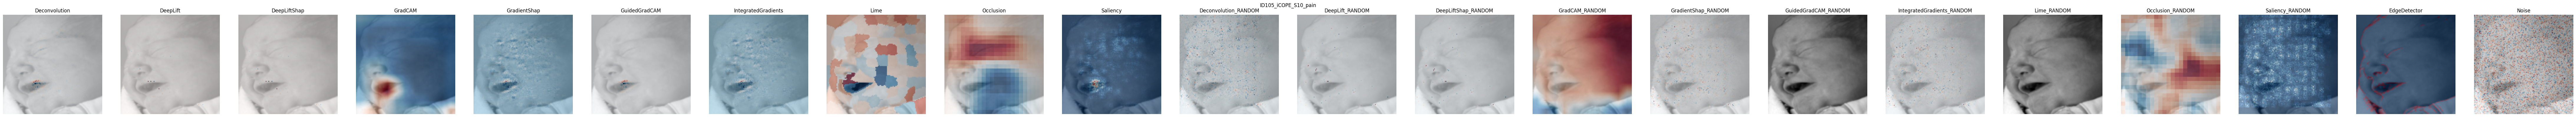

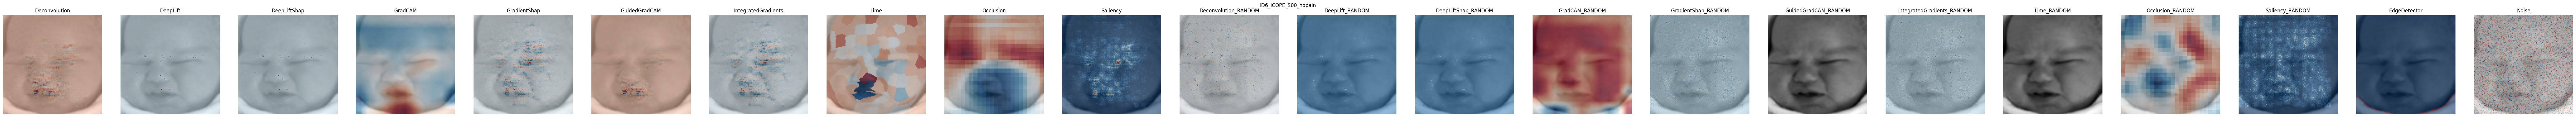

In [10]:
target_ids = ["ID105_iCOPE_S10_pain", "ID6_iCOPE_S00_nopain"]

subset = {
    sample_id: samples[sample_id]
    for sample_id in target_ids
}

plot_xai_overlays(subset)

## Average Plots

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def build_average_heatmaps_from_dict(
    explanations: dict[str, dict[str, np.ndarray]],
    labels: tuple[str, ...] = ("nopain", "pain"),
    label_getter=None,
) -> tuple[dict[str, dict[str, np.ndarray]], dict[str, dict[str, int]]]:
    """Compute per-label mean heatmaps for each explainer from an explanations dict."""
    labels = tuple(labels)
    if label_getter is None:
        suffix_map = {label: f"_{label}" for label in labels}
        def label_getter(sample_id: str) -> str:
            sample_lower = sample_id.lower()
            for label, suffix in suffix_map.items():
                if sample_lower.endswith(suffix):
                    return label
            raise ValueError(f"Could not infer label for sample '{sample_id}'")
    avg_maps = {label: {} for label in labels}
    file_counts = {label: {} for label in labels}

    for sample_id, expl_dict in explanations.items():
        label = label_getter(sample_id)
        for explainer, heatmap in expl_dict.items():
            if heatmap is None:
                continue
            data = np.asarray(heatmap, dtype=np.float32)

            valid = np.isfinite(data)

            total = avg_maps[label].setdefault(explainer, np.zeros_like(data, dtype=np.float64))
            count = file_counts[label].setdefault(explainer, np.zeros_like(data, dtype=np.float64))
            total[valid] += data[valid]
            count[valid] += 1

    for label in labels:
        for explainer in list(avg_maps[label].keys()):
            total = avg_maps[label][explainer]
            count = file_counts[label][explainer]
            valid = count > 0
            if not np.any(valid):
                del avg_maps[label][explainer]
                del file_counts[label][explainer]
                continue
            avg = np.zeros_like(total, dtype=np.float32)
            avg[valid] = (total[valid] / count[valid]).astype(np.float32)
            avg_maps[label][explainer] = avg
            file_counts[label][explainer] = int(np.max(count))  # number of contributing heatmaps

    return avg_maps, file_counts

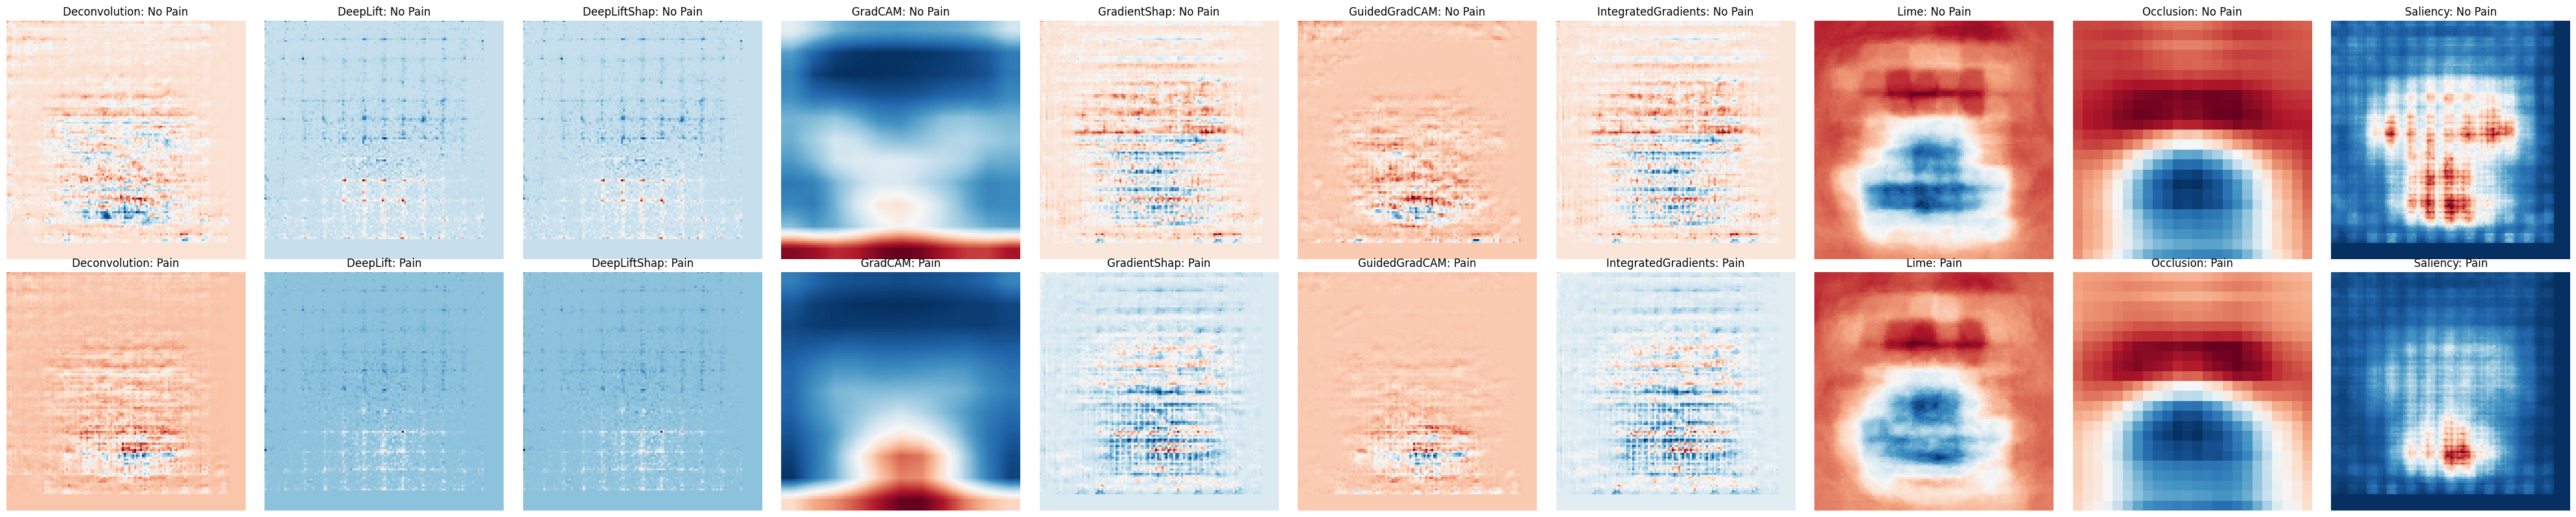

In [57]:
labels = ("nopain", "pain")
average_heatmaps, file_counts = build_average_heatmaps_from_dict(samples, labels=labels)

explainer_names = sorted({name for maps in average_heatmaps.values() for name in maps})
rows = len(labels)
cols = len(explainer_names)

save_root: Path | str | None = Path(r"D:\### DOUTORADO\Mestrado\RGU\XAI_EXPLAINERS\imgs")  # or None to skip saving
save_dpi = 300
if save_root is not None:
    save_root = Path(save_root)
    save_root.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows), squeeze=False)

for row, label in enumerate(labels):
    for col, explainer in enumerate(explainer_names):
        ax = axes[row, col]
        heatmap = average_heatmaps[label].get(explainer)
        if heatmap is None:
            ax.axis("off")
            continue

        im = ax.imshow(heatmap, cmap="RdBu_r")
        ax.axis("off")
        title_label = "Pain" if label == "pain" else "No Pain"
        ax.set_title(f"{explainer}: {title_label}")

        if save_root is not None:
            file_name = f"{label}_{explainer}.png".replace(" ", "_")
            fig_save, ax_save = plt.subplots(figsize=(4, 4))
            ax_save.imshow(heatmap, cmap="RdBu_r")
            ax_save.axis("off")
            fig_save.savefig(save_root / file_name, dpi=save_dpi, bbox_inches="tight", pad_inches=0)
            plt.close(fig_save)

plt.tight_layout()
plt.show()


# 5. Correlations with Random, Canny, and Noise

SSIM and Spearman

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from skimage.metrics import structural_similarity as ssim
from skimage.color import rgb2gray

def spearman_and_ssim(img_a: np.ndarray, img_b: np.ndarray) -> tuple[float, float]:
    """Return Spearman rank correlation and SSIM between two images."""
    if img_a.shape != img_b.shape:
        raise ValueError("Images must share shape.")

    flat_a = img_a.flatten()
    flat_b = img_b.flatten()
    rho, _ = spearmanr(flat_a, flat_b)

    if img_a.ndim == 3 and img_a.shape[-1] == 3:
        img_a_gray = rgb2gray(img_a)
        img_b_gray = rgb2gray(img_b)
    else:
        img_a_gray = img_a
        img_b_gray = img_b

    data_range = img_b_gray.max() - img_b_gray.min()
    if data_range == 0:
        data_range = 1.0

    ssim_val = ssim(img_a_gray, img_b_gray, data_range=data_range)
    return rho, ssim_val

records = []
for sample_id, explainers in tqdm(samples.items()):
    names = list(explainers.keys())
    for i, name_a in enumerate(names):
        for name_b in names[i + 1:]:
            img_a = np.asarray(explainers[name_a])
            img_b = np.asarray(explainers[name_b])
            rho, ssim_val = spearman_and_ssim(img_a, img_b)
            records.append({
                "sample_id": sample_id,
                "explainer_a": name_a,
                "explainer_b": name_b,
                "spearman": rho,
                "ssim": ssim_val,
            })

metrics_df = pd.DataFrame(records)
metrics_df.to_csv(Path(f"RGU\\XAI_EXPLAINERS\\explainers_correlation_{model_name_aux}_align_{align}_method_{method}.csv"), index=False)

In [ ]:
def average_pairwise_matrix(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    explainers = sorted(set(df["explainer_a"]).union(df["explainer_b"]))
    pair_means = (
        df.assign(pair=df.apply(lambda r: tuple(sorted((r["explainer_a"], r["explainer_b"]))), axis=1))
          .groupby("pair")[metric]
          .mean()
    )

    matrix = pd.DataFrame(np.nan, index=explainers, columns=explainers, dtype=float)
    for (a, b), value in pair_means.items():
        matrix.at[a, b] = value
        matrix.at[b, a] = value
    np.fill_diagonal(matrix.values, 1.0)
    return matrix

def plot_average_heatmap(df, metric, ax=None, cmap="viridis"):
    matrix = average_pairwise_matrix(df, metric)
    if metric == "spearman":
        vmin, vmax = -1, 1
    else:
        vmin, vmax = 0, 1

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 5))

    sns.heatmap(
        matrix,
        ax=ax,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar=True,
        linewidths=0.5,
        square=True,
    )
    ax.set_title(f"{metric.upper()} — average across samples")
    ax.set_xlabel("Explainer")
    ax.set_ylabel("Explainer")
    return ax

def plot_and_save_average_heatmap(df, metric, cmap, outfile):
    fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)
    plot_average_heatmap(df, metric, ax=ax, cmap=cmap)
    plt.show()  # display in the notebook
    fig.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.close(fig)

plot_and_save_average_heatmap(metrics_df, "spearman", cmap="RdBu_r", outfile="avg_spearman_heatmap.pdf")
plot_and_save_average_heatmap(metrics_df, "ssim", cmap="RdBu_r", outfile="avg_ssim_heatmap.pdf")

# 6. Agreement

In [ ]:
import numpy as np
from pathlib import Path
from itertools import combinations
import pandas as pd
import glob
import pickle
import os
import cv2
from tqdm import tqdm

from XAI.metrics import create_face_regions_masks, calculate_xai_score

import numpy as np


def get_top_k_pixels(importance_map, k_percent=10):
    # Flatten the map and sort the pixels by importance
    flat_map = importance_map.flatten()
    threshold_value = np.percentile(flat_map, 100 - k_percent)
    top_k_mask = importance_map >= threshold_value

    return top_k_mask.astype('int')


def feature_agreement(mask_1, mask_2):
    # Compute the Intersection
    intersection = np.logical_and(mask_1, mask_2)
    union = np.logical_or(mask_1, mask_2)

    # Calculate Feature Agreement
    feature_agreement = np.sum(intersection) / np.sum(union)

    return feature_agreement


def merge_symmetric_masks(face_masks):
    # Define symmetric region mappings: (left_key, right_key) → new_key
    merge_map = {
        ('left_eye', 'right_eye'): 'eyes',
        ('left_cheek', 'right_cheek'): 'cheeks',
        ('left_eyebrown', 'right_eyebrown'): 'eyebrowns',
        ('left_nasolabial_fold', 'right_nasolabial_fold'): 'nasolabial_folds',
    }

    new_masks = {}
    used_keys = set()

    # Merge symmetric pairs
    for (left, right), new_key in merge_map.items():
        if left in face_masks and right in face_masks:
            new_masks[new_key] = np.logical_or(face_masks[left], face_masks[right]).astype(np.uint8)
            used_keys.update([left, right])

    # Keep all other regions that are not merged
    for key, mask in face_masks.items():
        if key not in used_keys:
            new_masks[key] = mask

    return new_masks


def calculate_region_agreement(importance_dict1, importance_dict2, k, return_agreed_set=False):
    # Sort each dictionary by importance and get the top k regions
    top_k_regions_1 = set(sorted(importance_dict1, key=importance_dict1.get, reverse=True)[:k])
    top_k_regions_2 = set(sorted(importance_dict2, key=importance_dict2.get, reverse=True)[:k])

    # Calculate the intersection of the top k regions
    agreed_regions = top_k_regions_1.intersection(top_k_regions_2)

    # Calculate the agreement score
    agreement_score = len(agreed_regions) / k

    if return_agreed_set:
        return agreement_score, agreed_regions
    else:
        return agreement_score


def pairwise_agreement(samples, k_pixel=10, k_region=3):
    path_mesh = 'Datasets\\DatasetFaces\\Landmarks'

    rows = []
    for sample_id, masks in tqdm(samples.items()):
        methods = sorted(masks)
        for left, right in combinations(methods, 2):
            mask_l = get_top_k_pixels(cv2.resize(masks[left], (512,512)), k_pixel)
            mask_r = get_top_k_pixels(cv2.resize(masks[right], (512,512)), k_pixel)
            
            if mask_l.shape != mask_r.shape:
                raise ValueError(f"Shape mismatch on '{sample_id}' between {left} and {right}.")
            
            agreement_score_pixel = feature_agreement(mask_l, mask_r)
            
            with open(os.path.join(path_mesh, sample_id+".pkl"), 'rb') as f:
                    mesh = np.array(pickle.load(f))
            
            regions = create_face_regions_masks(mesh)
            regions = merge_symmetric_masks(regions)

            xai_score_l = calculate_xai_score(mask_l, regions, sort=True)
            xai_score_r = calculate_xai_score(mask_r, regions, sort=True)

            agreement_score_region, agreed_regions = calculate_region_agreement(
                xai_score_l, xai_score_r, k_region, return_agreed_set=True
            )

            rows.append(
                dict(
                    sample=sample_id,
                    method_a=left,
                    method_b=right,
                    pixel=agreement_score_pixel,
                    region=agreement_score_region,
                    agreed_regions=sorted(agreed_regions)   # or ';'.join(sorted(agreed_regions))
                )
            )

    return pd.DataFrame(rows)

def extract_top_regions(
    samples,
    top_k=11,
    mask_size=(512, 512),
    landmark_dir=r"Datasets\DatasetFaces\Landmarks",
):
    rows = []
    for sample_id, method_masks in tqdm(samples.items(), desc="Samples"):
        mesh_path = Path(landmark_dir) / f"{sample_id}.pkl"
        if not mesh_path.exists():
            print(f"Skip {sample_id} (missing landmarks at {mesh_path})")
            continue

        with open(mesh_path, "rb") as f:
            mesh = np.array(pickle.load(f))

        regions = merge_symmetric_masks(create_face_regions_masks(mesh))

        for method, mask in method_masks.items():
            mask = np.nan_to_num(mask, copy=False)
            mask_resized = cv2.resize(mask, mask_size)
            mask_resized = get_top_k_pixels(mask_resized, 10)
            region_scores = calculate_xai_score(mask_resized, regions, sort=True)
            sorted_regions = sorted(region_scores, key=region_scores.get, reverse=True)[:top_k]
            rows.append(
                {
                    "sample": sample_id,
                    "explainer": method,
                    "regions": sorted_regions,  # store list directly
                }
            )

    return pd.DataFrame(rows)


def summarize_pairwise_pixel(agreements: pd.DataFrame) -> pd.DataFrame:
    agg = (
        agreements
        .groupby(["method_a", "method_b"])["pixel"]
        .agg(mean_pixel="mean", std_pixel="std", n="count")
        .reset_index()
        .sort_values("mean_pixel", ascending=False)
    )
    return agg


def summarize_pairwise_region(agreements: pd.DataFrame) -> pd.DataFrame:
    agg = (
        agreements
        .groupby(["method_a", "method_b"])["region"]
        .agg(mean_region="mean", std_region="std", n="count")
        .reset_index()
        .sort_values("mean_region", ascending=False)
    )
    return agg

import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import pickle

def aggregate_top_masks_per_sample(samples, k_percent=10):
    """Return per-sample heatmaps counting how many explainers flagged each pixel."""
    aggregated = {}
    for sample_id, method_masks in samples.items():
        stack = []
        for mask in method_masks.values():
            mask = np.nan_to_num(mask, copy=False)
            stack.append(get_top_k_pixels(mask, k_percent))
        if stack:
            aggregated[sample_id] = np.stack(stack).mean(axis=0)  # (H, W) agreement count
    return aggregated

def aggregate_region_scores(samples, k_percent=10, mask_size=(512, 512),
                            landmark_dir=Path(r"Datasets\DatasetFaces\Landmarks"), sort=True):
    """Return per-sample dictionaries giving average importance per face region across all explainers."""
    output = {}
    for sample_id, method_masks in samples.items():
        mesh_path = landmark_dir / f"{sample_id}.pkl"
        if not mesh_path.exists():
            continue

        with mesh_path.open("rb") as fh:
            mesh = np.array(pickle.load(fh))

        regions = merge_symmetric_masks(create_face_regions_masks(mesh))
        region_accumulator = {name: 0.0 for name in regions}
        region_counts = {name: 0 for name in regions}

        for mask in method_masks.values():
            mask = np.nan_to_num(mask, copy=False)
            mask_resized = cv2.resize(mask, mask_size)
            mask_binary = get_top_k_pixels(mask_resized, k_percent)
            region_scores = calculate_xai_score(mask_binary, regions, sort=False)
            for region_name, score in region_scores.items():
                region_accumulator[region_name] += score
                region_counts[region_name] += 1

        averaged_scores = {
            region: region_accumulator[region] / region_counts[region]
            for region in regions if region_counts[region] > 0
        }
        if sort:
            averaged_scores = dict(sorted(averaged_scores.items(),
                                          key=lambda kv: kv[1], reverse=True))
        output[sample_id] = averaged_scores
    return output

In [ ]:
if Path(f"RGU\\XAI_EXPLAINERS\\{model_name_aux}_agreement.csv").exists():
    agreements = pd.read_csv(f"RGU\\XAI_EXPLAINERS\\{model_name_aux}_agreement.csv")
else:
    agreements = pairwise_agreement(samples, k_pixel=10, k_region=3)
    agreements.to_csv(f"RGU\\XAI_EXPLAINERS\\{model_name_aux}_agreement.csv", index=False)

## Top regions by explainer

In [ ]:
import ast
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
top_regions_df = extract_top_regions(samples_trained, top_k=3)

In [ ]:
#top_regions_df["regions"] = top_regions_df["regions"].apply(ast.literal_eval)

counts = {}
for explainer, group in top_regions_df.groupby("explainer"):
    counter = Counter()
    for regions in group["regions"]:
        counter.update(regions)
    counts[explainer] = counter

if not counts:
    raise RuntimeError("No regions found to plot.")

all_regions = sorted({region for counter in counts.values() for region in counter})

heatmap_data = pd.DataFrame(
    {explainer: [counter.get(region, 0) for region in all_regions]
     for explainer, counter in counts.items()},
    index=all_regions,
)

percent_data = heatmap_data.div(heatmap_data.sum(axis=0), axis=1) * 100

plt.figure(figsize=(0.6 * len(percent_data.columns) + 4,
                    0.5 * len(percent_data.index) + 3))
sns.heatmap(
    percent_data,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar_kws={"label": "Percentage (%)"},
    linewidths=0.5,
    linecolor="white",
)
plt.title("Facial Region Frequency per Explainer (Percentage)")
plt.xlabel("Explainer")
plt.ylabel("Facial Region")
plt.tight_layout()
plt.show()


## Pixel Agreement

In [ ]:
summary = summarize_pairwise_pixel(agreements)
# assumes `summary` as from summarize_pairwise_iou(agreements)
methods = sorted(set(summary["method_a"]).union(summary["method_b"]))
matrix = summary.pivot(index="method_a", columns="method_b", values="mean_pixel").reindex(index=methods, columns=methods)

# mirror upper/lower triangles to fill the diagonal and lower half
matrix = matrix.combine_first(matrix.T)
np.fill_diagonal(matrix.values, 1.0)

plt.figure(figsize=(8, 7))
sns.heatmap(matrix, vmin=0, vmax=1, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Mean IoU Agreement Between Explainers")
plt.ylabel("Explainer A")
plt.xlabel("Explainer B")
plt.tight_layout()
plt.show()


### Overall Agreed Pixel by Pairs

### Overall Agreed Pixels by All

In [ ]:
pixel_heatmaps = aggregate_top_masks_per_sample(samples_trained)

def average_heatmap(aggregated_masks, target_label=None):
    """Mean of per-explainer heatmaps; optionally filter by suffix label."""
    selected = []
    for sample_id, heatmap in aggregated_masks.items():
        label = sample_id.rsplit("_", 1)[-1].lower()

        if label == "pain":
            parsed_label = "pain"
        elif label == "nopain":
            parsed_label = "nopain"
        else:
            continue  # skip IDs without a known suffix

        if target_label and parsed_label != target_label:
            continue

        selected.append(heatmap.astype(np.float32))

    if not selected:
        return None
    return np.mean(selected, axis=0)

overall_heatmap = average_heatmap(pixel_heatmaps)
pain_heatmap = average_heatmap(pixel_heatmaps, target_label="pain")
no_pain_heatmap = average_heatmap(pixel_heatmaps, target_label="nopain")

plt.figure(figsize=(15, 5))
for i, (heatmap, title) in enumerate(zip(
    [overall_heatmap, pain_heatmap, no_pain_heatmap],
    ["Overall Average Heatmap", "Pain Average Heatmap", "No Pain Average Heatmap"],
)):
    plt.subplot(1, 3, i + 1)
    if heatmap is not None:
        plt.imshow(heatmap, cmap="jet")
        plt.colorbar()
    plt.title(title)
    plt.axis("off")

## Region Agreement

In [ ]:
summary_regions = summarize_pairwise_region(agreements)
# assumes `summary` as from summarize_pairwise_iou(agreements)
methods = sorted(set(summary_regions["method_a"]).union(summary_regions["method_b"]))
matrix = summary_regions.pivot(index="method_a", columns="method_b", values="mean_region").reindex(index=methods, columns=methods)

# mirror upper/lower triangles to fill the diagonal and lower half
matrix = matrix.combine_first(matrix.T)
np.fill_diagonal(matrix.values, 1.0)

plt.figure(figsize=(8, 7))
sns.heatmap(matrix, vmin=0, vmax=1, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Mean IoU Agreement Between Explainers")
plt.ylabel("Explainer A")
plt.xlabel("Explainer B")
plt.tight_layout()
plt.show()

### Overall Agreed Regions by Pairs

In [ ]:
# Parse stringified lists
#agreements["agreed_regions"] = agreements["agreed_regions"].apply(lambda x: ast.literal_eval(x))

# Expand regions into long format
exploded = agreements.explode("agreed_regions")

# Count frequencies per explainer pair + region
region_counts = (
    exploded.groupby(["method_a", "method_b", "agreed_regions"])
    .size()
    .reset_index(name="count")
)

# Pivot into matrix (rows=pairs, cols=regions)
heatmap_data = region_counts.pivot_table(
    index=["method_a", "method_b"],
    columns="agreed_regions",
    values="count",
    fill_value=0
)

# ---- Convert to percentage (row-normalized) ----
heatmap_data_pct = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) * 100

# ---- Heatmap ----
plt.figure(figsize=(16,12))
sns.heatmap(heatmap_data_pct, annot=True, cmap="Blues", fmt=".1f")
plt.title("Region Agreement (%) per Explainer Pair")
plt.ylabel("Explainer Pair")
plt.xlabel("Region")
plt.show()

In [ ]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

def parse_regions(x):
    if isinstance(x, list):
        return x
    if pd.isna(x) or x.strip() == "" or x.strip() == "[]":
        return []
    return ast.literal_eval(x)

agreements["agreed_regions"] = agreements["agreed_regions"].apply(parse_regions)

agreements["condition"] = (
    agreements["sample"]
    .str.extract(r"(nopain|pain)", expand=False)
    .map({"pain": "Pain", "nopain": "No Pain"})
)

exploded = agreements.explode("agreed_regions").dropna(subset=["agreed_regions", "condition"])

condition_counts = (
    exploded.groupby(["condition", "agreed_regions"])
    .size()
    .rename("count")
    .reset_index()
)

condition_counts["percent"] = (
    condition_counts["count"]
    / condition_counts.groupby("condition")["count"].transform("sum")
    * 100
).round(2)

pivot = (
    condition_counts
    .pivot(index="agreed_regions", columns="condition", values="percent")
    .fillna(0)
)

pivot["Total"] = pivot.sum(axis=1)
pivot = pivot.sort_values("Total", ascending=True)
pivot = pivot.drop(columns="Total")

top_n = 15  # change or remove this line to plot all regions
plot_data = pivot.head(top_n)

plot_data.plot(
    kind="barh",
    stacked=True,
    figsize=(10, max(5, 0.4 * len(plot_data))),
)

plt.xlabel("Percentage of agreements (%)")
plt.ylabel("Region")
plt.title("Agreed Regions Across Explainer Pairs (stacked Pain vs No Pain)")
plt.legend(title="Class", loc="lower right")
plt.tight_layout()
plt.show()


### Overall Agreed Regions by All


In [ ]:
region_scores = aggregate_region_scores(samples_trained)

def region_summary(region_scores):
    """Average region importance overall and per class using ID suffixes."""
    rows = []
    for sample_id, regions in region_scores.items():
        label = sample_id.rsplit("_", 1)[-1].lower()
        if label == "pain":
            parsed_label = "pain"
        elif label == "nopain":
            parsed_label = "nopain"
        else:
            continue

        for region, score in regions.items():
            rows.append(
                {"sample": sample_id, "label": parsed_label, "region": region, "score": score}
            )

    df = pd.DataFrame(rows)
    overall = df.groupby("region")["score"].mean().sort_values(ascending=False)
    per_label = df.groupby(["label", "region"])["score"].mean().unstack(0).sort_values(
        by="pain", ascending=False
    )
    return overall, per_label

overall_region_mean, per_label_region_mean = region_summary(region_scores)

In [ ]:
overall_region_mean

In [ ]:
per_label_region_mean

# 7. Metrics

# 8. PCA